# Ricardo D. Andrade Rodríguez, Data Scientist

# Modelo Deep Learning para Detección de Fake News 

  A continuación se presenta un **modelo Neural Network (Red Neuronal) de Deep Learning para Detectar Fake News** construido a través de la librería Keras. 
  
  El modelo pretende "aprender" a distinguir de manera autónoma entre una Noticia Real y una Fake News utilizando una [base de datos](https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset/data) de 1,500 noticias reales y 1,500 noticias Fake news (consideradas así en la vida real) de los años 2017 al 2019 en el idioma inglés.
 
  La estrategia a seguir es crear un **espacio vectorial $R^n$ (debido a que bajo mi experiencia 'one-hot' encoding distorsiona mucho el espacio de datos)** donde $n=\{total\ de\ palabras\ en\ el\ diccionario\}$ para luego entrenar el modelo parar que pueda aprender a "distinguir las zonas" en el plano y crear límites de decisión (desicion boundaries) para su correcta clasificación. 
  
  Un ejemplo sencillo en 2D sería el siguiente

  <img src='https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2020/01/Scatter-Plot-of-Binary-Classification-Dataset.png' width=560 />

   

In [ ]:
# General Liberies to manipulate data
import pandas as pd 
import collections
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

# Liberies for the Model

from keras.models import Sequential
from keras.layers import Dense, Embedding, Flatten, Input
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
# Loading the Data

true = pd.read_csv('/content/True.csv')
fake = pd.read_csv('/content/Fake.csv')
fake.head(10)

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"
5,Racist Alabama Cops Brutalize Black Boy While...,The number of cases of cops brutalizing and ki...,News,"December 25, 2017"
6,"Fresh Off The Golf Course, Trump Lashes Out A...",Donald Trump spent a good portion of his day a...,News,"December 23, 2017"
7,Trump Said Some INSANELY Racist Stuff Inside ...,In the wake of yet another court decision that...,News,"December 23, 2017"
8,Former CIA Director Slams Trump Over UN Bully...,Many people have raised the alarm regarding th...,News,"December 22, 2017"
9,WATCH: Brand-New Pro-Trump Ad Features So Muc...,Just when you might have thought we d get a br...,News,"December 21, 2017"


In [ ]:
#Label Data {0 = Fake News, 1 = True}

fake['Label']='fake'
fake['Label_value']=0
true['Label']='true'
true['Label_value']=1

full_data = fake.append(true,ignore_index=True)

#Cleannign Data & Creating Dictionary  
x = full_data[full_data.columns[1]].str.replace(',|\.|\'|‘|’|\?|:|;|!', " ")
y = ' '.join(x)
temp = y.split()
dic_freq = collections.Counter(temp)

#Dictionary to Dataframe
dic_freq_df = pd.DataFrame.from_dict(dic_freq, orient='index').reset_index()
dic_freq_df = dic_freq_df.rename(columns={'index':'Word', 0:'count'})

words_universe = dic_freq_df[dic_freq_df.columns[0]]
integer_mapping = {x: i for i,x in enumerate(words_universe)}

In [ ]:
# Vector pre-Positions in R_n
final=[]
vec=[]
testing2 = x.to_frame()
testing2 = testing2.rename(columns={0:'phrase'})

for k in range(len(testing2)):    
    m = testing2.iloc[k,0]
    vec=[]
    for i in m.split():
          vec.append(integer_mapping.get(i)+1) # +1 due 0 can be viewed as the 'first' word value
    final.append(sorted(list(set(vec))))       #sorted & unique values in list

In [ ]:
# Creation of the Vector Positions in R_n

n=len(words_universe)

def my_function(final,n):
    master_vec_pos = []
    for k in range(len(final)):
        temp = np.zeros(n,dtype=int)
        for i in range(len(final[k])):
            temp[final[k][i]-1] = final[k][i]
        master_vec_pos.append(temp)
    return master_vec_pos

final2 = my_function(final,n)
final2 = pd.DataFrame(final2)

##Análisis del vector resultante

Se obtuvieron un total de 46,301 columnas, o visto de otro modo, un diccionario con más de 46 mil palabras. Por lo que un vector de la siguiente manera

$ x_{3} = (1,2,0,0,5,0,7,...)$

nos indica que la **Noticia 3** contiene en su TEXTO las palabras número 1,2,5 y 7. Nótese que  el vector $x$ forma un punto en el plano $R^n$, el cual deberá ser clasificado por el modelo.

In [ ]:
#Previsualización de la matriz obtenida del conjunto de noticias

final2.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,46261,46262,46263,46264,46265,46266,46267,46268,46269,46270,46271,46272,46273,46274,46275,46276,46277,46278,46279,46280,46281,46282,46283,46284,46285,46286,46287,46288,46289,46290,46291,46292,46293,46294,46295,46296,46297,46298,46299,46300
0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,2,3,0,5,0,0,0,9,0,11,0,13,0,15,16,17,0,19,20,21,0,0,24,25,0,0,28,0,0,0,0,0,0,35,36,37,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,2,3,0,5,0,0,0,9,0,0,0,13,0,15,16,17,0,19,20,21,22,0,24,25,0,0,28,0,0,31,32,33,0,35,0,0,0,39,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,2,0,0,5,0,7,0,9,0,0,0,13,0,15,16,17,0,19,0,21,0,0,24,25,0,0,28,0,0,0,0,0,34,35,36,37,38,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,2,3,0,0,0,7,0,9,0,0,0,13,14,15,0,17,0,19,20,21,0,0,24,25,0,0,28,0,0,0,0,0,34,0,0,0,0,39,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Agregando el valor del Label {0 = Fake News, 1 = True}
final2['Label_value'] = full_data.iloc[:,-1]  

#Splitting Train and Test set
train, test = train_test_split(final2, test_size=0.2)

In [ ]:
# ----- Building The Model  -----------------------------------------
  
input_dim = len(words_universe)+1
output_dim = 8
lenght_data = len(words_universe)  # only if will be conected to Flatten layer and
                                   # then a Dense layer
model = Sequential()
model.add(Embedding(input_dim, output_dim, input_length=lenght_data))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

# summarize the model
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 46301, 8)          370416    
_________________________________________________________________
flatten (Flatten)            (None, 370408)            0         
_________________________________________________________________
dense (Dense)                (None, 1)                 370409    
Total params: 740,825
Trainable params: 740,825
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# Fitting the model  -----------------------------------------------

data = np.array(train.iloc[:,:-1])              # final2.iloc[:,:-1] also do the job
labels_train= np.array(list(train.iloc[:,-1]))  #labels_train= list(train.iloc[:,-1])


history = model.fit(data, labels_train, epochs=50, verbose=0)

##Evaluación del Modelo: Gráfica *Loss Function* y *Accuracy*

Las siguientes gráficas muestran **cómo el modelo 'tardó en aprender' a diferenciar las Fake News**. Una caída rápida en la función de pérdida (Loss function) nos indica que el modelo no tardó en aprender a diferenciar las Fake News, de manera inversa un crecimiento abrupto en "Accuracy" muestra la precisión del modelo para diferenciar fue rápida.

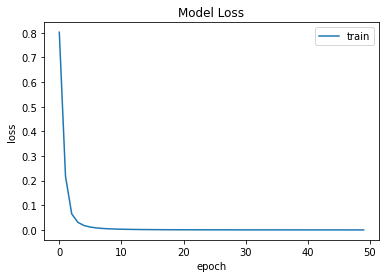

In [ ]:
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')
plt.show()

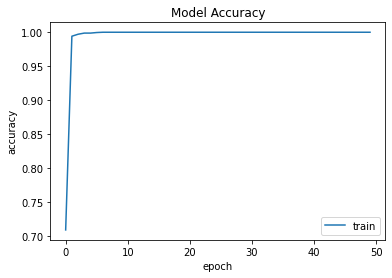

In [ ]:
plt.plot(history.history['acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.show()

##Evaluación del Modelo: *Accuracy, Final Loss*

El modelo obtuvo una presición (accuracy) del 100.000%, y una pérdida del 0.00755%.

In [ ]:
# evaluate the model  ------------------------------------------
loss, accuracy = model.evaluate(data, labels_train, verbose=0)
print('Accuracy: %f' % (accuracy*100))
print('Loss: %f' % (loss*100))


Accuracy: 100.000000
Loss: 0.007550


##Realizando predicciones con el Modelo para detectar Fake News

Como parte de las Buenas Prácticas, realizamos el pronóstico con datos nuevos (testing data) para evitar **"over fitting"**.

In [ ]:
# Make a Prediction using test data

data = np.array(test.iloc[:,:-1])  # final2.iloc[:,:-1] also do the job
labels_test= list(test.iloc[:,-1])

results= pd.DataFrame(list(zip(model.predict(data),np.array(labels_test))),
                   columns =['Prediction', 'Real Value'])

La toma de decisión es si la probabilidad de la predicción es mayor a 0.5,entonces se considera $True\ News=\{1\}$ y $Fake\ News=\{0\}$.Para esto tendremos que transformar nuestros datos.



In [ ]:
results.head(5)

,Prediction,Real Value
0,[4.0883908e-08],0
1,[0.999998],1
2,[4.9419858e-05],0
3,[1.1002978e-06],0
4,[0.0059396923],0


In [ ]:
# Creating a function to apply to each row of the data frame
def prediction_adjust(value):
	"""Rounds up to {1} if value is greater than 0.5 (True News), {0} other (Fake News).	"""
	if value>0.5:
		return(1)
	else:
		return(0)

In [ ]:
results['Prediction_Adjusted'] = results['Prediction'].apply(prediction_adjust)
results.head(10)

,Prediction,Real Value,Prediction_Adjusted
0,[4.0883908e-08],0,0
1,[0.999998],1,1
2,[4.9419858e-05],0,0
3,[1.1002978e-06],0,0
4,[0.0059396923],0,0
5,[0.000109571876],0,0
6,[0.99999726],1,1
7,[0.9999972],1,1
8,[0.00043097138],0,0
9,[0.0002911985],0,0


## Matríz de Cofusión

 La útima evaluación que desarrollaremos para analizar el desempeño del Modelo es la Matríz de Confusión. La Matriz compara el valor real versus el valor pronósticado por el Modelo de Machine Learning.
 
 

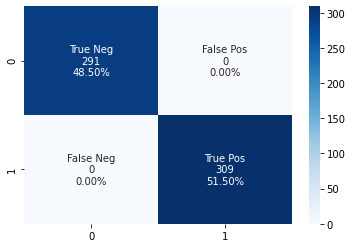

In [ ]:
cf_matrix  = confusion_matrix(results['Real Value'] , results['Prediction_Adjusted'] )

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
                
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
                     
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')